In [73]:
import pysam
import os
import glob
%matplotlib inline
import matplotlib.pyplot as plt
from genepeeks.common import utilities as util
import numpy as np
import itertools
import tabletext

In [2]:
DMD_ensembl = util.Mongo.get_collection_data('gene', wanted_db='prod', query={'_id': 'DMD'}, find_one=True, single_field='ensembl')
DMD_exons = util.get_nested_value(DMD_ensembl, ('is_primary', 'transcripts', 'is_primary', 'exons'))
DMD_exons_merged = util.merge_intervals(DMD_exons, min_dist=200)

Finished loading ensembl within the gene collection from the genepeeks-prod database with a single entries with a query of {'_id': 'DMD'} after 0.07 sec


In [60]:
# bam_files_folder = '../../library_files/inputs/bam_files'
insert_lengths_d = {}
for root, dirs, files in os.walk('/mnt/vep/subjects'):
    for file_name in files:
        if file_name.endswith('.bam'):
            if '{}.bai'.format(file_name) not in files:
                print '{} is missing an index file'.format(file_name)
                continue

            file_path = os.path.join(root, file_name)
            subject = os.path.splitext(file_name)[0]
            print subject
            bamfile = pysam.AlignmentFile(file_path, "rb")
            for read in bamfile.fetch('X', start=31137345, end=33229636):
                if not read.is_unmapped and read.mapping_quality == 60 and not read.mate_is_unmapped:
                    all_positions = [read.reference_start, read.reference_end, read.next_reference_start]
                    for position in all_positions:
                        interval_info = util.in_interval(read.reference_start, DMD_exons_merged, get_interval=True)
                        if interval_info[0]:
                            exon_num = interval_info[1]
                            break
                    else:
                        continue

                    if read.is_reverse == read.mate_is_reverse:
                        orientation = 'Tandem'
                        # orientation = 'Tandem-{}'.format('R' if read.is_reverse else 'F')
                    elif read.is_reverse:
                        orientation = 'RF'
                    else:
                        orientation = 'FR'
#                         if read.template_length < 0:
#                             continue
#                             print subject, read.template_length, read.reference_start, read.next_reference_start

                    util.add_to_dict(insert_lengths_d, orientation, read.template_length, keep_values=True, nested_key=exon_num)


FCLR-GP01-2121
MESB-0009-690N
MMCB-0000-209K
MESB-0009-662M
MCLR-CD00-0270
FRCH-0000-0018
FPWB-0000-429L
MESB-0009-568C
MMCB-0005-8481
MCLR-NA20-928S
MRMR-0011-266B
MESB-0009-593J
FF2E-0000-361V
MMCB-0000-107Q
MESB-0008-694G
MMCB-0000-275L
FPWB-0000-9879
FGPC-0000-5279
FRMR-00SC-714V
MESB-0009-721Q
MCLR-ND12-099Y
FPWB-0001-173X
MMCB-0000-142W
MMCB-0000-119L
MMCB-0000-338H
MESB-0009-794D
MCLR-NA20-7442
MMCB-0000-331V
FRMR-00CS-821F
FPWB-0001-243Y
FRMR-0081-1987
MGPC-IX11-XL5T
MMCB-0000-1210
MESB-0008-703P
MESB-0008-7796
MMCB-0000-312V
MMCB-0009-233K
FRMR-0085-579V
MMCB-0000-144S
FPWB-0001-083Y
MESB-0009-773H
FM1W-0000-149Y
MRCH-0000-005L
MESB-0009-676D
FGPC-0000-492E
FPWB-0000-957C
MMCB-0000-291R
MMCB-0000-137N
FRMR-00DM-853C
MMCB-0008-858X
MMCB-0007-2978
FK1E-0000-332T
FGPC-1PR1-SON4
MRMR-0080-829K
MMCB-0000-106S
MRCH-0000-002R
MMCB-0000-278F
FPWB-0001-183W
MMCB-0000-315P
FRMR-00NC-7632
MMCB-0007-204N
MMCB-0000-122Y
MESB-0008-534O
MRMR-0040-6444
FCLR-GP20-9287
FCLR-NA17-435H
MMCB-0007-

In [95]:
wanted_bam = '/mnt/vep/subjects/MMCB-0000-144S/MMCB-0000-144S.bam'
bamfile = pysam.AlignmentFile(wanted_bam, "rb")
bam_version = next(PG['VN'] for PG in bamfile.header['PG'] if PG.get('ID') == 'bwa')
print bam_version
print len(bamfile.header['PG'])
print len(bamfile.header['RG'])

# for read in bamfile.fetch('X', start=31165413, end=31165413):
#     print read.reference_start, read.template_length


0.7.10-r789
63
3


661.0


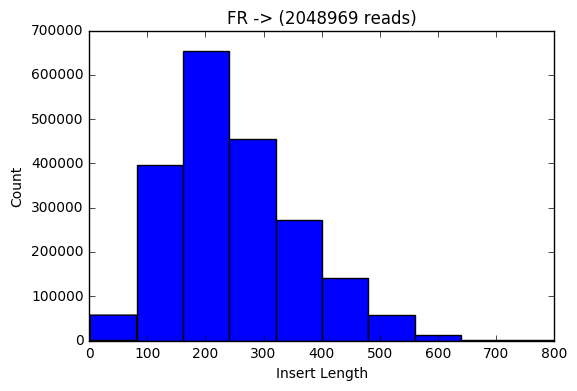

-22728381.107
Tandem -> (67 reads)
-668.0


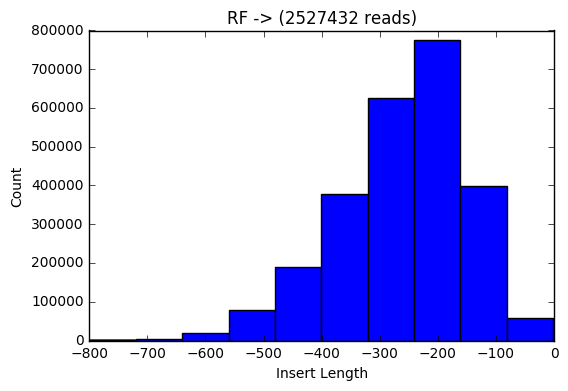

┌───────┬───────────────┬─────────────────┬───────────────┬─────────────────┐
│ Exon  │ FR Read Count │ FR 99.9% Cutoff │ RF Read Count │ RF 99.9% Cutoff │
├───────┼───────────────┼─────────────────┼───────────────┼─────────────────┤
│     1 │        193723 │           692.0 │        190555 │          -690.0 │
├───────┼───────────────┼─────────────────┼───────────────┼─────────────────┤
│     2 │          1251 │           648.5 │          3663 │        -578.676 │
├───────┼───────────────┼─────────────────┼───────────────┼─────────────────┤
│     3 │         26976 │         688.025 │         18013 │        -639.952 │
├───────┼───────────────┼─────────────────┼───────────────┼─────────────────┤
│     4 │         26949 │         608.052 │         17572 │          -676.0 │
├───────┼───────────────┼─────────────────┼───────────────┼─────────────────┤
│     5 │         25125 │           666.0 │         32331 │         -639.01 │
├───────┼───────────────┼─────────────────┼───────────────┼─────

In [94]:
exon_outlier_marks = [['Exon', 'FR Read Count', 'FR 99.9% Cutoff', 'RF Read Count', 'RF 99.9% Cutoff']]
exon_stats_dict = {}
for orientation, exon_insert_lengths in insert_lengths_d.items():
    if orientation == 'FR':
        min_insert = 0
        max_insert = 800
    else:
        min_insert = -800
        max_insert = 0
    total_orien_insert_lengths = list(itertools.chain(*exon_insert_lengths.values()))
    print np.percentile(total_orien_insert_lengths, 99.9 if orientation == 'FR' else 0.1)
    clipped_insert_lengths = [item for item in total_orien_insert_lengths if min_insert < item < max_insert]            
    title = "{} -> ({} reads)".format(orientation, len(clipped_insert_lengths))
    if orientation == 'Tandem':
        print title
        continue
    
    # Plot a histogram of distribution of insert lengths across all exons for each orientation
    plt.hist(clipped_insert_lengths)
    plt.title(title)
    plt.xlabel("Insert Length")
    plt.ylabel("Count")
    plt.show()
    
    exon_stats_dict[orientation] = {}
    for exon_index, insert_lengths in exon_insert_lengths.items():
        exon_stat = np.percentile(insert_lengths, 99.9 if orientation == 'FR' else 0.1)
        if exon_index == 64:
            exon = '65/66'
        elif exon_index > 64:
            exon = exon_index + 2
        else:
            exon = exon_index + 1
        if orientation == 'FR':
            exon_outlier_marks.append([exon, len(insert_lengths), exon_stat, None, None])
        else:
            exon_outlier_marks[exon_index + 1][3:] = [len(insert_lengths), exon_stat]
        exon_stats_dict[orientation][exon_index] = exon_stat
print tabletext.to_text(exon_outlier_marks)

In [92]:
for root, dirs, files in os.walk('/mnt/vep/subjects'):
    for file_name in files:
        if file_name.endswith('.bam') and file_name == 'MMCB-0000-144S.bam':
            if '{}.bai'.format(file_name) not in files:
                print '{} is missing an index file'.format(file_name)
                continue

            file_path = os.path.join(root, file_name)
            subject = os.path.splitext(file_name)[0]
            subject_outliers = {}
            print subject
            bamfile = pysam.AlignmentFile(file_path, "rb")
            for read in bamfile.fetch('X', start=31137345, end=33229636):
                if not read.is_unmapped and read.mapping_quality == 60 and not read.mate_is_unmapped:
                    all_positions = [read.reference_start, read.reference_end, read.next_reference_start]
                    for position in all_positions:
                        interval_info = util.in_interval(read.reference_start, DMD_exons_merged, get_interval=True)
                        if interval_info[0]:
                            exon_num = interval_info[1]
                            break
                    else:
                        continue

                    insert_length = read.template_length
                    if read.is_reverse == read.mate_is_reverse:
                        orientation = 'Tandem'
                    elif read.is_reverse:
                        orientation = 'RF'
                        if insert_length < exon_stats_dict[orientation][exon_num] * 1.05:
                            util.add_to_dict(subject_outliers, exon_num)
                            print orientation, exon_num, insert_length, exon_stats_dict[orientation][exon_num]
                    else:
                        orientation = 'FR'
                        if insert_length > exon_stats_dict[orientation][exon_num] * 1.05:
                            util.add_to_dict(subject_outliers, exon_num)
                            print orientation, exon_num, insert_length, exon_stats_dict[orientation][exon_num]

            exon_outliers = {k: v for k, v in subject_outliers.iteritems() if v > 2}
            if exon_outliers:
                print subject, exon_outliers


MMCB-0000-144S
FR 0 747 692.0
FR 0 799 692.0
FR 0 816 692.0
FR 0 730 692.0
RF 0 -747 -690.0
RF 0 -799 -690.0
RF 0 -816 -690.0
RF 0 -730 -690.0
FR 5 655 615.0
FR 28 779 673.0
FR 28 769 673.0
RF 34 -864 -697.508
RF 38 -1006 -705.54
FR 51 717 682.851
FR 53 785 696.0
FR 53 802 696.0
RF 70 -822 -601.58
FR 75 757 693.104
MMCB-0000-144S {0: 8}
